In [3]:
import json
import os
from google.colab import drive


In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [16]:
token = os.getenv('GITHUB_TOKEN')
repo_name = 'Emberflurry/Boillet_DT_Sim_v1'
file_name = 'boilletmain_setup2.ipynb'
commit_message = 'Automatic backup from Colab'
backup_path = '/content/drive/MyDrive/MDSCFP25/' + file_name
if os.path.exists(backup_path):
    print(f"Found {backup_path}, proceeding with backup.")
else:
    raise FileNotFoundError(f"File not found: {backup_path}")
!git config --global user.email "juandelbosque373@gmail.com"
!git config --global user.name "Emberflurry"
if os.path.exists('Boillet_DT_Sim_v1'):
    !rm -rf Boillet_DT_Sim_v1
!git clone https://{os.environ['GITHUB_TOKEN']}@github.com/{repo_name}.git
%cd Boillet_DT_Sim_v1
!cp {backup_path} .
with open(backup_path, 'r') as f:
    notebook_data = json.load(f)
for cell in notebook_data.get('cells', []):
    if cell.get('cell_type') == 'code':
sanitized_path = backup_path.replace('.ipynb', '_sanitized.ipynb')
with open(sanitized_path, 'w') as f:
    json.dump(notebook_data, f, indent=1)

print(f"Sanitized notebook saved to: {sanitized_path}")
!cp {sanitized_path} .
!git add {os.path.basename(sanitized_path)}
!git commit -m "{commit_message}"
!git push origin main

Found /content/drive/MyDrive/MDSCFP25/boilletmain_setup2.ipynb, proceeding with backup.
Cloning into 'Boillet_DT_Sim_v1'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 30 (delta 14), reused 21 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 516.80 KiB | 6.46 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/Boillet_DT_Sim_v1
Sanitized notebook saved to: /content/drive/MyDrive/MDSCFP25/boilletmain_setup2_sanitized.ipynb
[main 65acbdb] Automatic backup from Colab
 1 file changed, 148 insertions(+), 42 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 2.18 KiB | 2.18 MiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/E

In [ ]:
# later: add in muscle lactate kinetics from supplement, then add in OBLA/blood lactate ests or formula
# TODO: try special 3min-allout power test (req special loop config i think)
# TODO: turn loop into a callable (ie: simulatable function!)
#add lactate curve (see supplement), at least for sub LT1 seems aight

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.patches as patches
from matplotlib.animation import PillowWriter
from google.colab import files
from datetime import datetime
import shutil
import pytz

239 total seconds of test
Current Time = 02.17_03_35PM
Ptank failure not reached, assigned at t= 238 s
Pmec failure not reached, assigned at t= 238 s


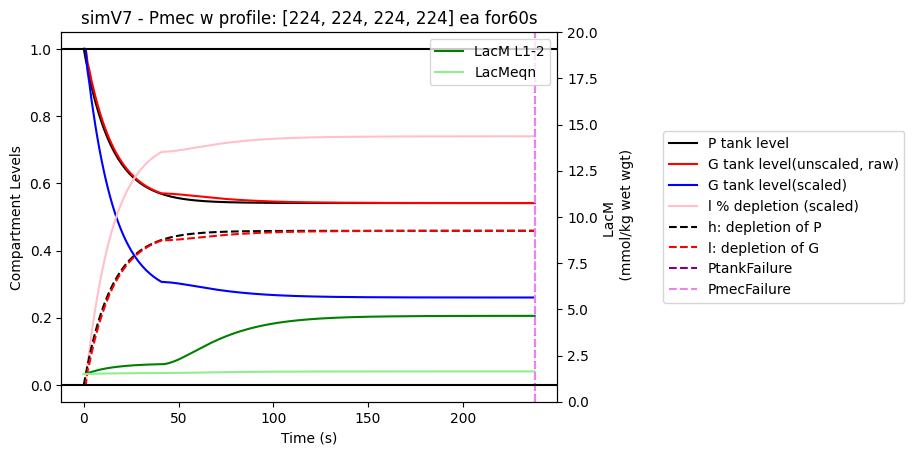

W from O2@end 224.0 W. i think correct
@end Pmax theo.: 970.27 W
VO2max of athlete: 64.1 ml/kg/min, at weight in kg of 64kg?? (need calc)
Max effective Pmec from aerobic?? 341.8 W (potential/limit) idk if right/useful tho
WRONG FIX Crit Power % of VO2max (aerobic component only): 83.1 % see note below
from sims: LT1@190w(18.5%Max) / LT2@247w(24.0%Max) TODO FIX FROM PAPER SHOULD BE 280W CP
from SuppFormulae: P@LT1= 210.0 w?
from SuppForm. P@CP= 280.0 w. checks out w paper
(Beta= 0.82 )
@end h, l, theta | w/eta: 0.2551
0.46 0.46 0.43
Pmec@tfail(P=0): 224 w Pmec@tfailtheomax(G=0): 224 w
LacM L1-2 @end: 4.65 mmol/kg wet wgt
LacM eqn @end: 1.64 mmol/kg wet wgt


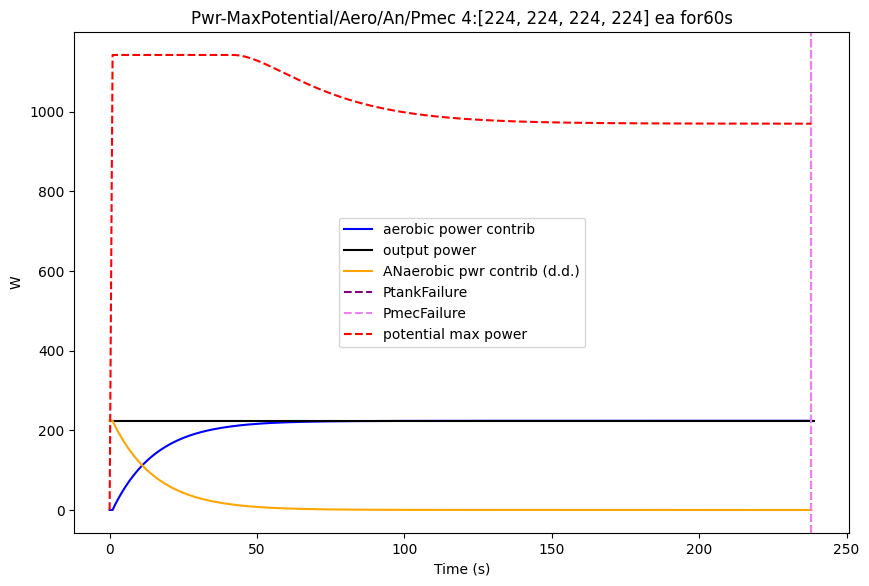

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Folder 'simV8_02.17_03_35PM' with figures has been zipped and downloaded.


Text(0.5, 1.0, 'dl_dt')

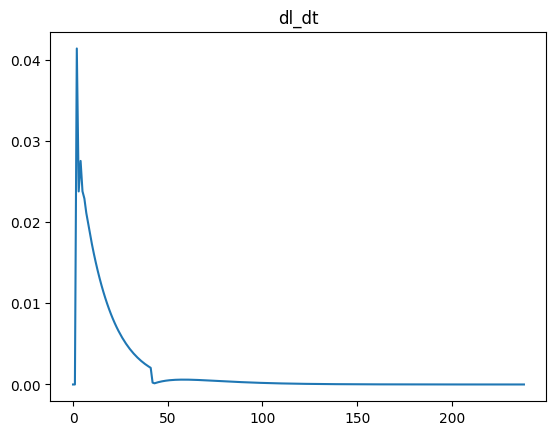

In [14]:
#V8 trying to fix VO2 dynamics and lactate fitting
#V7: adding lactate dynamics and other tests
#V6: has anim of tanks, and live readouts. outputs a gif to downloads local folder lol.
#V5: trying to get actual L height dynamics with capillary A_T
#V4: redoing dl/dt and dV_G/dt tank calcs. works better. 2/4 early morn lol

param_c1 = { # for Cyclist 1
    'eta': 0.2551,  # Efficiency factor = Pmec@LT1/(%VO2max@LT1 * VO2max * C1)
    'MO': 1.34,   # Max oxidative energy flux (kJ/s)
    'MP': 4.48,   # Max mechanical power (kJ/s) = Pmec(max) / eta
    'MG': 9.15,   # Max glycolytic flux (kJ/s). MG of 285J/kg(muscle mass involved in task)
    'MR': 3.66,   # Max lactate recovery rate (kJ/s) = MG/2.5
    'AP': 27.79,  # Phosphagen store (kJ)
    'AG': 320.3,  # Glycolytic store (kJ)
    'AT': 11.27,  # Capillary glycolytic store (kJ) = [La]muscle@LT1 / theta * massMuscle * C2 (i think all over)
    'phi': 0.30,  # Height of O relative to P
    'theta': 0.43,  # Depth of G relative to P
    'lamb': 0.38  # Height of G relative to P
}
MG = param_c1['MG']
eta = param_c1['eta']
MP = param_c1['MP']
MR = param_c1['MR']
MO = param_c1['MO']
AG = param_c1['AG']
AP = param_c1['AP']
AT = param_c1['AT']
phi = param_c1['phi']
theta = param_c1['theta']
lamb = param_c1['lamb']
P_height = 1
#duration = 270  # 1 minut3
#numbers = [100, 125,150,175,200,225,250,275,300,325,350, 375]
#numbers = [100,290,300,310,320,330,330]
#numbers = [175,200,225,250,275,300,325,350, 375]
#numbers = [100, 125,150,175,200,225,250,200,150,100,50,220,280,350]
#numbers = [100,200,300,315]
#numbers = [400,400,400]
#numbers = [150,200,250,260,270,280,290,300,310,320] #cyclist 1 investigating props around CP 280W
#numbers = [295,295,295,295,295,295,295,295]
#numbers = [250,260,270,280,290,300,310,320] #betw LT1, CP. for L3 (Heavy Work Rate Region)
#numbers = [170,170,170,170,170] #sub LT1 testing
#numbers = [310,320,330,340,350,360,370,380,390,400,410,420] #severe domain testing
#numbers = [13.6,27.2,40.8,54.4,68,82,95,109,122,136,150,163,177,190,204,218,231,245,258,272,286,299,313,326] #fig 5B should fail at ~300 W
#numbers = [320,340,360,380]
#numbers = [180,200,240,280,320]
#numbers = [200,240,280,330]
#numbers = [200,260,310,370]
#numbers = [170,170,170,170]
#numbers = [230,230]
#numbers = [400,500]
#numbers = [170,210,250,280,320,400,500]
numbers = [200,200,200]
numbers = [224,224,224,224]
#numbers = [295,295,295,295,295,295,295,295,295,295]
reps = 60
repeated_numbers = np.repeat(numbers, reps)
repeated_list = repeated_numbers.tolist()
duration = len(repeated_list)-1
print(duration,'total seconds of test')
h_init = 0 # 0 is P = full i think. 1 = P empty
l_init = 0 #param_c1['theta'] # or 0?? # 0 is G=full, 1-lamb is G empty? very not sure on this one
C1=20.9 # J/ml energy/ml of oxygen, Fixed for now
C2=100 #J/mmol joules/accum lac in muscle
C3= 43.3 #J/mmol joules/PC stores in working muscles assuming all can be fully depleted (not true tech)
dl_dt_init = 0 #given in suppP1
df1 = pd.DataFrame(np.zeros((duration, 19)),
                   columns=['h', 'l', 'Pmec', 'Pphys', 'P', 'G','Po2','Pmaxtheo',
                            'Failure',"G %(rel.)",'Lreal','LacM','LacM_eqn',
                            'VO2_eqn','VO2_eqn_adj','l %(rel.)','LacM_lrel',
                            'dl_dt','dh_dt'])
df1.loc[0, 'h'] = h_init
df1.loc[0, 'l'] = l_init
df1.loc[0,'l %(rel.)'] = l_init #fix to relative?
df1.loc[0, 'P'] = 1  #P init full
df1.loc[0, 'G'] = 1  #G init empty
df1.loc[0,'G %(rel.)'] = 1
df1.loc[0,'Lreal'] = l_init #full capillary.
df1.loc[0,'LacM'] = 1.5 #see main p6 for biopsy determ. 1.5mmol/kg wet wgt at rest TODO: make more indiv?
df1.loc[0,'LacM_eqn'] = 1.5 #see main p6 for biopsy determ. 1.5mmol/kg wet wgt at rest TODO: make more indiv?
df1.loc[0,'LacM_lrel'] = 1.5
dt=1 #second
variable_pwr = True
global t_fail, t_fail_maxpwr, t_failcurVmax
t_fail = 0
t_fail_maxpwr = 0
t_failcurVmax = 0

pheight = 5
pwidth = 10

local_timezone = pytz.timezone('America/New_York')  # Replace with your time zone
now = datetime.now(local_timezone)
# Format the date and time
current_time = now.strftime("%m.%d_%I_%M%p")  # Format: MM.DD_HH:MMam/pm
print("Current Time =", current_time)
folder_name = f"simV8_{current_time}"  # Folder name with timestamp
output_folder = f"/content/{folder_name}"  # Save in Colab's current directory

# Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

tank_gif_name = os.path.join(output_folder, f"simV8tank_gif_{current_time}.gif")
#output_file = 'simV6gif1.gif'# didnt workr"C:\Users\John DeForest\Downloads\sine_wave_animation.gif"
pwriter =  PillowWriter(fps=6)
fig1, ax1 = plt.subplots() #lowerleft coord of rect
fig1.set_size_inches(pwidth, pheight)
ax1.set_xlim(0, pwidth)
ax1.set_ylim(0, 1)
pwriter.setup(fig1, tank_gif_name)


for i in range(1, duration):
    h_prev = df1.loc[i-1, 'h']
    l_prev = df1.loc[i-1, 'l']
    Pmec = repeated_list[i] / 1000 #conv raw W power profile to kJ/sec
    Pphys = Pmec / param_c1['eta'] # in kJ/sec of demand.
    VO2 = min(MO * (h_prev / (1 - phi)), MO) # kJ/sec, from suppP2. power from O2 alone. # AKA: D_(O->P)
    df1.loc[i,'Po2']=VO2 * 1000 * eta #effective Pmec from current O2, in Watts (J/sec)
    Pmax_theo_t = MP # kJ/sec, physiological power, NOT MECHANICAL
    if l_prev > theta: #from indicator fn suppP1
      Pmax_theo_t = Pmax_theo_t * ((1 - lamb - l_prev)/(1-lamb-theta))
    elif l_prev <= theta:
      Pmax_theo_t = Pmax_theo_t * ((1 - lamb - theta)/(1-lamb-theta))
    df1.loc[i,'Pmaxtheo'] = Pmax_theo_t * 1000 * param_c1['eta'] # in Watts (J/sec)


    #TODO: add checks to make sure fluxes dont exceed MG/MR/MO etc
    unsc_dl_dt = ((h_prev - l_prev)/(1 - lamb)) #"fluid volume" change (took dl * baseArea(arb))
    if unsc_dl_dt < 0: #negative dl, G heading UP = RECOVERY FLUX GOVERNED BY MR
      if l_prev <= theta: #fluid lvl alr up in capillary, dl gov. by AT
        dl_dt = (MR/AT) * ((h_prev - l_prev)/(1 - lamb)) #supp p1,2: eqns 2
      elif l_prev > theta: #fluid lvl in Gtank, but could move up to capillary
        hG = l_prev - theta #get height of GtankTop above l_prev
        dl1 = hG
        if abs(MR*unsc_dl_dt) > hG * AG: #going to go up capillary
          spillover = abs(MR*unsc_dl_dt) - (hG * AG)
          dl2 = spillover / AT
          dl_dt = - (dl1 + dl2) #dl1 always pos here, dl2 also always pos^, ^^. so dl_dt needs to b neg.
        elif abs(MR*unsc_dl_dt) <= hG * AG: #NOT going to go up cap
          dl_dt = MR*unsc_dl_dt / AG #unscdl should b neg, so dldt should b neg.
      else:
        print('unsc_dl_dt neg, error w/ fluid lvl relative to capillary-UP')

    elif unsc_dl_dt >= 0: #positive dl, G heading DOWN, gov by MG
      if l_prev >= theta: #fluid lvl alr down in Gtank, dl gov. by AG
        dl_dt = (MG/AG) * ((h_prev - l_prev)/(1 - lamb)) #supp p1,2: eqns 22
      elif l_prev < theta: #fluid lvl in capillary, but could move down to Gtank
        hT = theta - l_prev #get height of fluid in capillary down to top of Gtank
        dl1 = hT
        if abs(MG*unsc_dl_dt) > hT * AT: #going to go down to Gtank
          spillover = abs(MG*unsc_dl_dt) - (hT * AT)
          dl2 = spillover / AG
          dl_dt =  (dl1 + dl2) #dl1 alw pos, dl2 pos, so dldt pos. G goes down.
        elif abs(MG*unsc_dl_dt) <= hT * AT: #NOT going to go down to Gtank
          dl_dt = MG*unsc_dl_dt / AT #unscdl should b pos, so dldt should b
      else:
        print('unsc_dl_dt pos, error w/ fluid lvl relative to capillary-DOWN')
    else:
      print('unsc_dl_dt error - other')

    df1.loc[i,'dl_dt'] = dl_dt
    #doesnt work check units ig????? FIX TODO HELP
    #wrong bc of signage errors: #dh_dt = -(Pphys - VO2 - abs(unsc_dl_dt)) / AP #see paper deriv backside. needs unscl for volume apples to apples.
    #TODO FIX dl_dt SCALING - figure out flux equiv???: i think wrong v: bc dldt is not a "volume" (kJ/sec) like the other quantities
    dh_dt = (Pphys - VO2 - dl_dt) / AP #my deriv see paper diag. dV_G = - dl/dt?
    df1.loc[i,'dh_dt'] = dh_dt
    #print('dh_dt',dh_dt)
    # if (h_prev + (dh_dt * dt)) > P_height or (h_prev + (dh_dt * dt)) <0:
    #   #break #ignore print for now
    #   print('attNewH',h_prev + (dh_dt * dt)) # means attempted to do a dh that is impossibly big :(
    # if (l_prev + (dl_dt * dt)) > P_height - param_c1['lamb'] or (l_prev + (dl_dt * dt)) <0:
    #   #break #ignore print for now
    #   print('attNewL',l_prev + (dl_dt * dt)) # means attempted to do a dl that is impossibly big :(
    df1.loc[i, 'h'] = max(0, min(1, h_prev + (dh_dt * dt)))  # [0 to 1]
    df1.loc[i, 'l'] = max(0, min(1-lamb, l_prev + (dl_dt * dt)))  # [theta(or zero?) to 1-lamb]
    df1.loc[i, 'Pphys'] = Pphys
    df1.loc[i, 'P'] = 1-df1.loc[i, 'h']
    df1.loc[i, 'G'] = 1-df1.loc[i, 'l']
    df1.loc[i, 'G %(rel.)'] = (df1.loc[i, 'G'] - lamb) / (1-lamb)
    df1.loc[i, 'l %(rel.)'] = 1-df1.loc[i, 'G %(rel.)']
    df1.loc[i, 'VO2_eqn'] = df1.loc[i-1, 'VO2_eqn'] + ( (1/C1)* (MO/(1-phi)) * dl_dt)  + ((1/C1)*1000*(df1.loc[i, 'Pphys'] - df1.loc[i-1, 'Pphys']))
    #*C1*60*eta #VO2 evol in L3. should be now in W (mechanical/effective)
    df1.loc[i,'VO2_eqn_adj'] = df1.loc[i, 'VO2_eqn'] *60 #ml O2 per minute

    h_curr = df1.loc[i, 'h']
    l_curr = df1.loc[i, 'l']
    Pphys_curr = df1.loc[i, 'Pphys']
    Pmec_curr = repeated_list[i] #in Watts output power
    Po2_curr = df1.loc[i, 'Po2']
    P_curr = df1.loc[i, 'P']
    G_curr = df1.loc[i, 'G']
    G_rel_curr = df1.loc[i, 'G %(rel.)']
    l_rel_curr = df1.loc[i,'l %(rel.)']
    l_rel_prev = df1.loc[i-1,'l %(rel.)']
    dl_dt_rel = l_rel_curr - l_rel_prev
    #Pmax_theo_t_curr = df1.loc[i,'Pmaxtheo']

    ATcor = 11
    AGcor = 28.5
    #AGadd = .05

    # Determine dLacM/dt based on the lactate dynamics
    if l_prev <= theta:  # Below LT1
        #dLacM_dt = (1 / C2) * dl_dt * AT
        dLacM_dt = (1 / C2) * dl_dt * AT * ATcor
    elif theta < l_prev <= (1 - lamb):  # Between LT1 and Pcrit
        dLacM_dt = (1 / C2) * dl_dt * AG * AGcor
    else:  # Above Pcrit (Severe Work Rate)
        dLacM_dt = (1 / C2) * dl_dt * AG * AGcor # Same scaling but no equilibrium
    # Update lactate levels
    df1.loc[i, 'LacM'] = max(0, df1.loc[i - 1, 'LacM'] + (dLacM_dt * dt))
    df1.loc[i, 'LacM_eqn'] = 1.5 + (1/C2)*(l_curr*AT) if l_curr <= theta else 1.5 + (1/C2)*((l_curr-theta)*AG + theta*AT) # to check. for eqn 12 on supp p1
    #deprecated in favor of ^ # df1.loc[i, 'LacM'] = 1/C2*l_curr*AG  #TODO CHECK pemdas VALID??? THIS ONLY VALID FOR L3 (heavy work rate p2 supp)
    #df1.loc[i,'LacM_lrel'] = 1.5 + (1/C2) * dl_dt_rel * AT if l_curr <= theta else 1.5 + (1/C2) * (dl_dt_rel * AG + dl_dt_rel * AT)
    if l_curr <= theta:
      df1.loc[i,'LacM_lrel'] = 1.5 + (1/C2) * l_rel_curr * AT
    else:
      df1.loc[i,'LacM_lrel'] = 1.5 + (1/C2) * (l_rel_curr * AG + l_rel_curr * AT)

    if i > 1:
      if 1-df1.loc[i, 'h'] == 0: #failure to complete exercise when P = 0 = empty
        if t_fail == 0:
          t_fail = i
          print("Ptank failure at t=",i,'s, @',repeated_list[i],'W')
    if i > 1:
      if Pmax_theo_t <= 0.001:
        if t_fail_maxpwr == 0:
          t_fail_maxpwr = i
          print('Pmec failure at t=',t_fail_maxpwr,'s, @',repeated_list[i],'W')
    if i>1:
      if Pmec_curr > df1.loc[i,'Pmaxtheo']:
        if t_failcurVmax == 0:
          t_failcurVmax = i
          print('Pmec V Pmaxtheo failure at t=',t_failcurVmax,'s, @',repeated_list[i],'W')
    frames = duration
    pheight = 5
    pwidth = 10
    owid = (1/5) * pwidth
    gap1 = 1/10
    gap2=1/10
    remaining = pwidth - ((gap1+gap2+owid/5)*pwidth)
    remfrac = remaining / pwidth
    Pwid = (AP / (AP + AG)) * remfrac
    Gwid = (AG / (AP + AG)) * remfrac
    ohi = 1-phi

    G_kJ_left = 0
    if l_curr > theta:
      G_kJ_left = AG * G_rel_curr
    elif l_curr <= theta:
      G_kJ_left = AG*((1-theta-lamb)/(1-lamb)) + AT * ((theta-l_curr)/(1-lamb))

    ax1.clear()
    ax1.set_xlim(0, pwidth)
    ax1.set_ylim(0, 1)

    obox = patches.Rectangle((0, phi), owid, pheight, color='lightblue', alpha=0.3)
    ax1.add_patch(obox)

    annapwrtext = 'curANpwr: ' + str(round(Pmec_curr-Po2_curr,1)) + 'w (difDerived)'
    ax1.text(.41, 0.235, annapwrtext, transform=ax1.transAxes, fontsize=12, verticalalignment='top')
    oxypwrtext = 'cur Po2: ' + str(round(Po2_curr,1)) +'w'
    ax1.text(.01, 0.09, oxypwrtext, transform=ax1.transAxes, fontsize=12, verticalalignment='top')
    vo2curtext = 'relVO2cur: ' + str(round(VO2*1000/C1,1)) + ' ml/kg/min'
    ax1.text(.01, 0.15, vo2curtext, transform=ax1.transAxes, fontsize=12, verticalalignment='top')
    text1 = 'curPmec: ' + str(Pmec*1000) + 'w@t=' + str(i) + 's, (Pphys:' + str(round(Pphys*1000,1)) + 'w)'
    ax1.text(.2, 0.05, text1, transform=ax1.transAxes, fontsize=12, verticalalignment='top')
    GkJ_text = ', G kJ left: ' + str(round(G_kJ_left,2))
    text2 = 'G: ' + str(round( df1.loc[i, 'G'],2)) + ', G%:'+ str(round(df1.loc[i, 'G %(rel.)'] * 100,2)) + GkJ_text
    ax1.text(.41, 0.285, text2, transform=ax1.transAxes, fontsize=12, verticalalignment='top')
    text3 = 'P: ' + str(round(df1.loc[i, 'P'],2)) + ', h: ' + str(round(df1.loc[i, 'h'],2)) + ', l: ' + str(round(df1.loc[i, 'l'],2))
    ax1.text(.01, 0.25, text3, transform=ax1.transAxes, fontsize=12, verticalalignment='top')
    text4 = 'simV8-W profile: ' + str(numbers) + ' ea for' + str(reps) + 's'
    ax1.text(.25, 1.12, text4, transform=ax1.transAxes, fontsize=12, verticalalignment='top')
    pbox = patches.Rectangle((owid+(gap1*pwidth), 0), Pwid*pwidth, df1.loc[i, 'P'], color='grey', alpha=0.3)
    ax1.add_patch(pbox)
    gbox = patches.Rectangle((owid+(gap1*pwidth)+Pwid*pwidth+(gap2*pwidth), lamb),
                             Gwid*pwidth,df1.loc[i, 'G']-lamb , color='orange', alpha=0.3)
    ax1.add_patch(gbox)
    chimNotWidth = (Gwid*pwidth) - ((AT/AP)*(Pwid*pwidth))
    gchimNot = patches.Rectangle((owid+(gap1*pwidth)+Pwid*pwidth+(gap2*pwidth), 1-theta),
                                 chimNotWidth ,theta , color='white', alpha=0.85)
    ax1.add_patch(gchimNot)

    pwriter.grab_frame()

pwriter.finish()
plt.close(fig1)

tank_filename = os.path.join(output_folder, f"tank_{current_time}.png")
power_filename = os.path.join(output_folder, f"power_{current_time}.png")
#deprecated: saves to zip file now files.download(tank_gif_name)
#fig1.savefig('anim1.gif', writer='pillow')
if t_fail == 0:
  t_fail = duration-1
  print("Ptank failure not reached, assigned at t=",t_fail,'s')
if t_fail_maxpwr == 0:
  t_fail_maxpwr = duration-1
  print("Pmec failure not reached, assigned at t=",t_fail_maxpwr,'s')
if t_failcurVmax == 0:
  t_failcurVmax = duration-1
  print("Pmec V Pmaxtheo failure not reached, assigned at t=",t_failcurVmax,'s')

fig1,ax1 = plt.subplots()
fig1.figsize=(10, 5)
ax1.plot( df1['P'], label='P tank level',color='black')
ax1.plot( df1['G'], label='G tank level(unscaled, raw)', color='red')
ax1.plot( df1['G %(rel.)'], label='G tank level(scaled)', color='blue')
ax1.plot(df1['l %(rel.)'],label='l % depletion (scaled)',color='pink')
#ax1.plot(df1['LacM_lrel'],label='Lac fr relDep',color='purple')
ax1.plot( df1['h'], label='h: depletion of P', color='black',linestyle='--')
ax1.plot( df1['l'], label='l: depletion of G', color='red',linestyle='--')
ax1.axvline(t_fail, linestyle='--', color='purple', label='PtankFailure')
ax1.axvline(t_fail_maxpwr, linestyle='--', color='violet', label='PmecFailure')
ax1.axhline(1, linestyle='-', color='black')
ax1.axhline(0, linestyle='-', color='black')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Compartment Levels')
ax1.legend(loc="center left", bbox_to_anchor=(1.2, 0.5))
#plt.tight_layout()
tanktitletext = 'simV7 - Pmec w profile: ' + str(numbers) + ' ea for' + str(reps) + 's'
ax1.set_title(tanktitletext)

ax2=ax1.twinx()
ax2.plot(df1['LacM'],label='LacM L1-2',color='green')
ax2.plot(df1['LacM_eqn'],label='LacMeqn',color='lightgreen')
ax2.set_ylim(0,20)
ax2.set_ylabel('LacM \n (mmol/kg wet wgt)')
ax2.legend()
fig1.savefig(tank_filename)
plt.show()
print("W from O2@end",round(df1.loc[duration-1,'Po2'],1),"W. i think correct")
plt.close()

plt.figure(figsize=(10, 6.5))
plt.plot(df1['Po2'],color='blue',label='aerobic power contrib')
plt.plot(repeated_list, color='black',label="output power")
plt.plot(repeated_list[0:-1] - df1['Po2'], color='orange',label='ANaerobic pwr contrib (d.d.)' )

plt.axvline(t_fail, linestyle='--', color='purple', label='PtankFailure')
plt.axvline(t_fail_maxpwr, linestyle='--', color='violet', label='PmecFailure')
print('@end Pmax theo.:',round(df1.loc[duration-1,'Pmaxtheo'],2),'W')
plt.plot(df1['Pmaxtheo'],color='red',linestyle='--', label="potential max power")
plt.xlabel('Time (s)')
plt.ylabel('W')
plt.legend()
plt.title('Pwr-MaxPotential/Aero/An/Pmec 4:'+ str(numbers) + ' ea for' + str(reps) + 's')
print("VO2max of athlete:",round((param_c1['MO']*1000)/C1,1), "ml/kg/min, at weight in kg of 64kg?? (need calc)")
print("Max effective Pmec from aerobic??", round(((param_c1['MO']*1000*param_c1['eta']))  ,1),"W (potential/limit) idk if right/useful tho") # i think this is correct to show max mech watts from aerobic pwr
print("WRONG FIX Crit Power % of VO2max (aerobic component only):",round(100*param_c1['MO']*(1-param_c1['lamb']),1),"% see note below")
print("from sims: LT1@190w(18.5%Max) / LT2@247w(24.0%Max) TODO FIX FROM PAPER SHOULD BE 280W CP")
print('from SuppFormulae: P@LT1=',round(1000*eta*MO*(theta/(1-phi)),1),"w?")
print('from SuppForm. P@CP=',round(eta*((1-lamb)/( (1-phi)+(MO/MP)*(1-theta-lamb) ))*MO*1000,1),'w. checks out w paper')
print('(Beta=',round((1-lamb)/( (1-phi)+(MO/MP)*(1-theta-lamb) ),2),')')
print('@end h, l, theta | w/eta:',str(eta))
print(round(df1.loc[duration-1,'h'],2),round(df1.loc[duration-1,'l'],2),param_c1['theta'])
print('Pmec@tfail(P=0):',repeated_list[t_fail],'w','Pmec@tfailtheomax(G=0):',repeated_list[t_fail_maxpwr],'w')
print('LacM L1-2 @end:',round(df1.loc[duration-1,'LacM'],2),'mmol/kg wet wgt')
print('LacM eqn @end:',round(df1.loc[duration-1,'LacM_eqn'],2),'mmol/kg wet wgt')
plt.savefig(power_filename)
plt.show()
plt.close()
#depr files.download(power_filename)
#depr files.download(tank_filename)

zip_filename = f"/content/{folder_name}.zip"
shutil.make_archive(output_folder, 'zip', output_folder)
# Step 6: Download the zipped folder to your computer
from google.colab import files
files.download(zip_filename)
print(f"Folder '{folder_name}' with figures has been zipped and downloaded.")




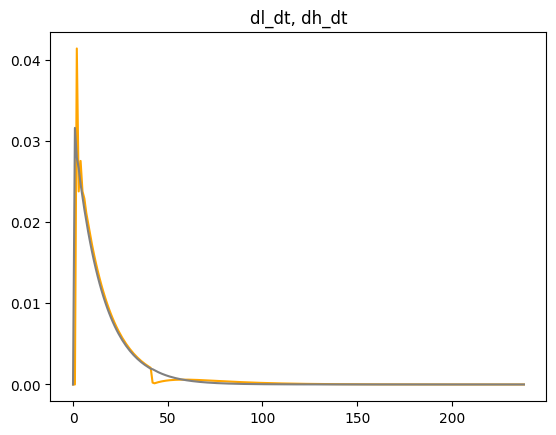

In [20]:
plt.figure()
#plt.plot(df1['VO2_eqn_adj'],color='purple',label='VO2 pwr from L3 eqn')
#VdotO2_evol_eqn_2 = (1/C1)*(df1['Pphys']+(MO*df1['l'])/(1-phi))
#plt.plot(VdotO2_evol_eqn_2,color='blue',label='VO2 pwr from eqn2')
plt.plot(df1['dl_dt'], color='orange')
plt.title("dl_dt, dh_dt")
plt.plot(df1['dh_dt'], color='grey')

In [ ]:
#issue: FIX TODO doesnt capture SS VO2drift to vo2max at supra threshold. maybe a fn of lactate? check boillet and fix difeq representation?
#wait hmm not sure if it is...^YES SEE SUPP p2 for VO2 Kinetics - this is sick bc we can see SS vo2 demand/response and Non-ss and find inefficiencies!!!!
#hmm yeah it doesnt deal with L3 i think - vo2 power comes up and there is no anaerobic power supply at L3... i think thats an issue. there should be some drift? not sure tbh
#maybe derive as a % of G box left? vol? area?height? idk. maybe this is fine. maybe itll all manifest in LACTATE (derived from G box level l.)

In [16]:
print(df1.loc[duration-1,'LacM'])
print(df1.loc[duration-1,'LacM_eqn'])
print(l_curr)

4.646611634295333
1.6403583492962006
0.4586910238202312


In [ ]:
print(df1['VO2_eqn'])


0      0.000000
1      0.180000
2      0.196237
3      0.205565
4      0.216367
         ...   
294    0.635640
295    0.636379
296    0.637122
297    0.637866
298    0.638613
Name: VO2_eqn, Length: 299, dtype: float64


In [ ]:
#TODO FIX: fix pmaxtheo to check against pcurrent for failure too. may shift failure point sig.

Text(0.5, 1.0, 'VO2 ml O2 / min at L3 VALID ONLY')

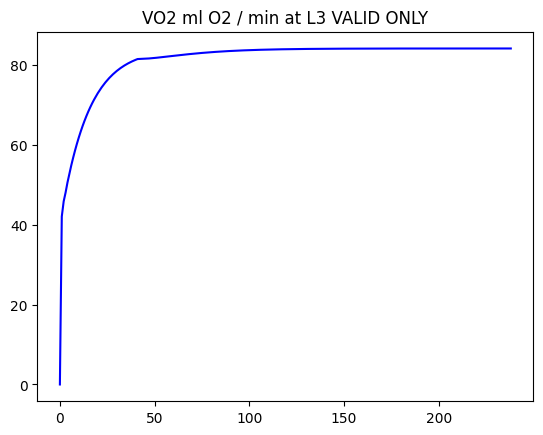

In [17]:
plt.figure()
#plt.plot(df1['VO2_eqn_adj'],color='purple',label='VO2 pwr from L3 eqn')
VdotO2_evol_eqn_2 = (1/C1)*(1000*df1['Pphys']+(1000*MO*df1['l'])/(1-phi))
plt.plot(VdotO2_evol_eqn_2,color='blue',label='VO2 pwr from eqn2')
plt.title("VO2 ml O2 / min at L3 VALID ONLY")

In [9]:
print(VdotO2_evol_eqn_2)

0       0.000000
1      42.013733
2      45.803522
3      47.980736
4      50.502256
         ...    
234    84.026247
235    84.026300
236    84.026350
237    84.026399
238    84.026445
Length: 239, dtype: float64


In [10]:
print(VdotO2_evol_eqn_2.to_string(index=False))

 0.000000
42.013733
45.803522
47.980736
50.502256
52.680879
54.777957
56.713214
58.528162
60.219735
61.800090
63.275183
64.652512
65.938381
67.138927
68.259789
69.306263
70.283283
71.195461
72.047099
72.842215
73.584561
74.277638
74.924718
75.528851
76.092890
76.619494
77.111148
77.570172
77.998732
78.398848
78.772410
79.121179
79.446801
79.750812
80.034646
80.299642
80.547052
80.778041
80.993700
81.195045
81.383028
81.404188
81.417321
81.437248
81.463136
81.494226
81.529829
81.569321
81.612134
81.657756
81.705724
81.755619
81.807065
81.859722
81.913285
81.967482
82.022068
82.076828
82.131566
82.186111
82.240314
82.294039
82.347171
82.399609
82.451265
82.502063
82.551940
82.600842
82.648725
82.695551
82.741292
82.785927
82.829438
82.871816
82.913055
82.953152
82.992110
83.029934
83.066634
83.102220
83.136705
83.170106
83.202438
83.233721
83.263975
83.293220
83.321477
83.348770
83.375120
83.400552
83.425088
83.448753
83.471570
83.493563
83.514755
83.535170
83.554832
83.573764
83.591988


In [11]:
VdotO2_evol_eqn_2.to_csv("column_data.csv", index=False)
from google.colab import files
files.download("column_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>